In [1]:
import pymysql
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import transformations
import config
%matplotlib inline

In [3]:
conn = pymysql.connect(config.host, user=config.username,port=config.port,
                           passwd=config.password)

#gather all historical data to build model
RideWaits = pd.read_sql_query("call DisneyDB.RideWaitQuery('2,7,8,9')", conn)

#transform data for model bulding
RideWaits = transformations.transformData(RideWaits)

C:\Users\Chrisrtopher\Documents\DisneyWaits\src\transformations.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  RideWaits["Month"] = RideWaits["Date"].dt.month
C:\Users\Chrisrtopher\Documents\DisneyWaits\src\transformations.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  RideWaits["TimeSinceRideOpen"] = (RideWaits["Date"] - RideWaits["OpeningDate"]).dt.days
C:\Users\Chrisrtopher\Documents\DisneyWaits\src\transformations.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [2]:
RideWaits[(RideWaits['inEMH'] == 1) & (RideWaits["MagicHourType"] == "Night")] 

NameError: name 'RideWaits' is not defined

In [4]:
RideWaits.columns

Index(['RideId', 'Date', 'Time', 'Wait', 'Name', 'OpeningDate', 'Tier',
       'Location', 'IntellectualProp', 'ParkId', 'ParkOpen', 'ParkClose',
       'EMHOpen', 'EMHClose', 'ParkName', 'DayOfWeek', 'Weekend',
       'CharacterExperience', 'inEMH', 'validTime', 'EMHDay', 'TimeSinceOpen',
       'TimeSinceMidday', 'MagicHourType', 'MinutesSinceOpen', 'Month',
       'TimeSinceRideOpen'],
      dtype='object')

In [5]:
important_columns = ['RideId', 'Wait','Name','Tier','Location','IntellectualProp','ParkId','DayOfWeek','Weekend','CharacterExperience','inEMH','EMHDay','TimeSinceOpen','TimeSinceMidday','MagicHourType','MinutesSinceOpen','Month']

In [6]:
ride_waits = RideWaits[important_columns]

In [7]:
ride_waits = ride_waits.dropna(how = "any")

In [8]:
ride_waits.shape

(92419, 17)

In [9]:
ride_waits['Tier'].value_counts()

minor_attraction    37140
major_attraction    21154
super_headliner     13486
headliner           12991
diversion            7648
Name: Tier, dtype: int64

In [10]:
ride_waits['Location'].value_counts()

Fantasyland                      23422
Future World                     14551
Tomorrowland                      7465
Adventureland                     4822
World Showcase                    4645
Toy Story Land                    4326
DinoLand U.S.A.                   4174
Main Street, U.S.A.               2985
Echo Lake                         2971
Pandora   The World of Avatar     2935
Animation Courtyard               2919
Sunset Boulevard                  2864
Discovery Island                  2855
Frontierland                      2836
Asia                              2616
Liberty Square                    1609
Commissary Lane                   1493
Africa                            1485
Grand Avenue                      1395
                                    51
Name: Location, dtype: int64

In [11]:
ride_waits = ride_waits[ride_waits['Location'] != ""]

In [12]:
ride_waits['IntellectualProp'].value_counts()

None        34413
Princess    15350
Pixar       13496
Fab5        11300
Animated     6105
StarWars     4398
Avatar       2935
Pirates      1511
Pooh         1465
Muppets      1395
Name: IntellectualProp, dtype: int64

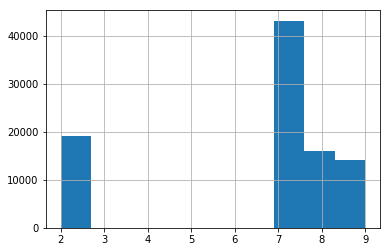

In [13]:
ride_waits['ParkId'].hist()

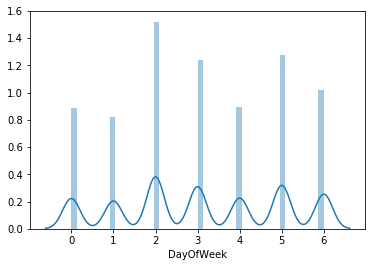

In [14]:
sns.distplot(ride_waits['DayOfWeek'])

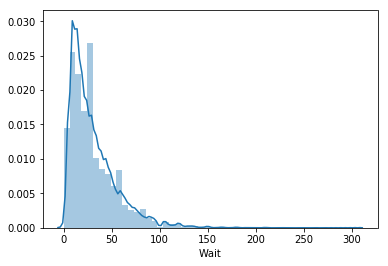

In [15]:
sns.distplot(ride_waits['Wait'])

In [16]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    df = df.drop([column_name], axis = 1)
    return df

In [17]:
import seaborn as sns


def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

In [18]:
ride_waits.columns

Index(['RideId', 'Wait', 'Name', 'Tier', 'Location', 'IntellectualProp',
       'ParkId', 'DayOfWeek', 'Weekend', 'CharacterExperience', 'inEMH',
       'EMHDay', 'TimeSinceOpen', 'TimeSinceMidday', 'MagicHourType',
       'MinutesSinceOpen', 'Month'],
      dtype='object')

In [19]:
dummy_columns = ['RideId','Tier','Location','IntellectualProp','ParkId','DayOfWeek','Weekend','CharacterExperience','inEMH','EMHDay','MagicHourType','Month']


In [20]:
dummy_columns

['RideId',
 'Tier',
 'Location',
 'IntellectualProp',
 'ParkId',
 'DayOfWeek',
 'Weekend',
 'CharacterExperience',
 'inEMH',
 'EMHDay',
 'MagicHourType',
 'Month']

In [21]:
for column in dummy_columns:
    ride_waits = create_dummies(ride_waits, column)
    

In [22]:
for col in ride_waits.columns:
    print(col)

Wait
Name
TimeSinceOpen
TimeSinceMidday
MinutesSinceOpen
RideId_46
RideId_20194
RideId_26068
RideId_62992
RideId_78704
RideId_107785
RideId_136550
RideId_207395
RideId_209857
RideId_387133
RideId_15743682
RideId_15850196
RideId_16124144
RideId_16491297
RideId_16767263
RideId_16767276
RideId_16767284
RideId_16874126
RideId_17272158
RideId_17421326
RideId_17505397
RideId_17564219
RideId_17752793
RideId_18189394
RideId_18360041
RideId_18361662
RideId_18368385
RideId_18368386
RideId_18375495
RideId_18498503
RideId_18665185
RideId_18665186
RideId_18669338
RideId_18904138
RideId_18904172
RideId_80010107
RideId_80010110
RideId_80010114
RideId_80010117
RideId_80010123
RideId_80010129
RideId_80010149
RideId_80010150
RideId_80010151
RideId_80010152
RideId_80010153
RideId_80010154
RideId_80010157
RideId_80010161
RideId_80010162
RideId_80010170
RideId_80010173
RideId_80010176
RideId_80010177
RideId_80010178
RideId_80010182
RideId_80010190
RideId_80010191
RideId_80010192
RideId_80010193
RideId_8001

In [23]:
ride_waits = ride_waits.drop(['Name'], axis = 1)

In [24]:
correlation = ride_waits.corr()['Wait']
correlation

Wait                         1.000000
TimeSinceOpen               -0.017436
TimeSinceMidday             -0.107802
MinutesSinceOpen            -0.018876
RideId_46                         NaN
RideId_20194                 0.014837
RideId_26068                -0.001712
RideId_62992                -0.104175
RideId_78704                -0.003653
RideId_107785               -0.089437
RideId_136550               -0.072823
RideId_207395               -0.093131
RideId_209857                0.095676
RideId_387133               -0.061589
RideId_15743682             -0.039519
RideId_15850196              0.041974
RideId_16124144             -0.034549
RideId_16491297             -0.061741
RideId_16767263             -0.078106
RideId_16767276             -0.006541
RideId_16767284              0.231428
RideId_16874126              0.000294
RideId_17272158             -0.014670
RideId_17421326             -0.028530
RideId_17505397              0.010389
RideId_17564219             -0.025281
RideId_17752

In [25]:
correlation = ride_waits.corr()['Wait']
key_correlations = correlation[abs(correlation) > .075]

In [26]:
key_correlations

Wait                                      1.000000
TimeSinceMidday                          -0.107802
RideId_62992                             -0.104175
RideId_107785                            -0.089437
RideId_207395                            -0.093131
RideId_209857                             0.095676
RideId_16767263                          -0.078106
RideId_16767284                           0.231428
RideId_18375495                           0.102822
RideId_18665185                           0.216266
RideId_18665186                           0.396912
RideId_18904138                           0.215545
RideId_80010117                          -0.113116
RideId_80010150                          -0.088938
RideId_80010151                          -0.099252
RideId_80010152                          -0.087601
RideId_80010162                          -0.099701
RideId_80010170                          -0.099897
RideId_80010176                           0.143063
RideId_80010182                

In [27]:
important_cols = list(key_correlations.index)

In [28]:
important_cols = [x for x in important_cols if x != "Wait"]

In [29]:
ride_waits_key = ride_waits[important_cols + ["Wait","MinutesSinceOpen"]]

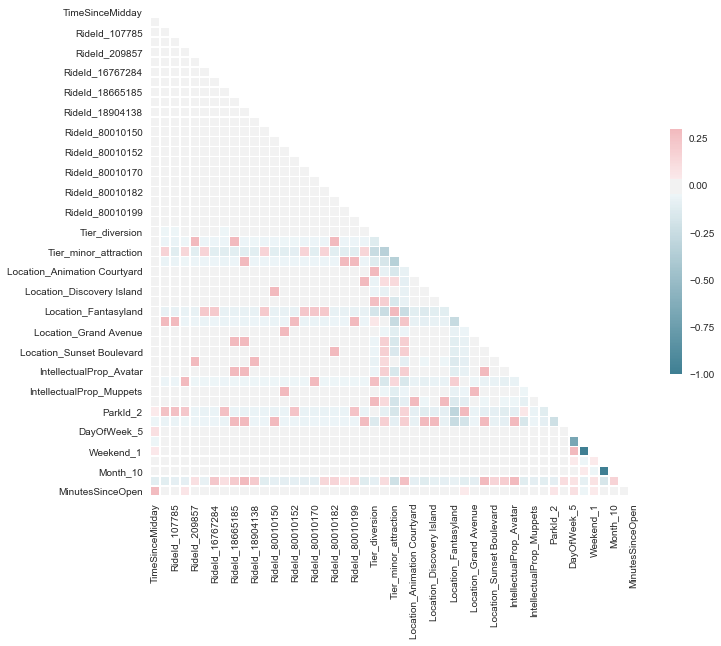

In [30]:
plot_correlation_heatmap(ride_waits_key)

In [ ]:
#things that are highly correlated to each other are the weekend thing, because if it's not a weekend it is a weekday
#we don't need include all levels of each set

In [31]:
important_cols = [x for x in important_cols if x != "Weekend_0"]

In [ ]:
important_cols

In [32]:
important_cols = important_cols + ["MinutesSinceOpen"]

In [ ]:
important_cols

In [33]:
data = ride_waits_key

In [34]:
important_cols

['TimeSinceMidday',
 'RideId_62992',
 'RideId_107785',
 'RideId_207395',
 'RideId_209857',
 'RideId_16767263',
 'RideId_16767284',
 'RideId_18375495',
 'RideId_18665185',
 'RideId_18665186',
 'RideId_18904138',
 'RideId_80010117',
 'RideId_80010150',
 'RideId_80010151',
 'RideId_80010152',
 'RideId_80010162',
 'RideId_80010170',
 'RideId_80010176',
 'RideId_80010182',
 'RideId_80010190',
 'RideId_80010199',
 'RideId_80010228',
 'Tier_diversion',
 'Tier_headliner',
 'Tier_minor_attraction',
 'Tier_super_headliner',
 'Location_Animation Courtyard',
 'Location_DinoLand U.S.A.',
 'Location_Discovery Island',
 'Location_Echo Lake',
 'Location_Fantasyland',
 'Location_Future World',
 'Location_Grand Avenue',
 'Location_Pandora   The World of Avatar',
 'Location_Sunset Boulevard',
 'Location_Toy Story Land',
 'IntellectualProp_Avatar',
 'IntellectualProp_Fab5',
 'IntellectualProp_Muppets',
 'IntellectualProp_StarWars',
 'ParkId_2',
 'ParkId_9',
 'DayOfWeek_5',
 'Weekend_1',
 'Month_9',
 'Mont

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression(normalize = True)
scores = cross_val_score(lr, data[important_cols], data['Wait'], scoring = "neg_median_absolute_error", cv = 10)
mean_error_lr = scores.mean()
print(mean_error_lr)

-8.87828008188


In [36]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
scores = cross_val_score(rf, data[important_cols],data['Wait'], scoring = "neg_median_absolute_error", cv = 10)
mean_error_rf = scores.mean()
print(mean_error_rf)

-6.75469511912


In [37]:
#maybe since it's time dependent we should add information about the previous step wait time

In [38]:
def get_shift(day, steps):
    previous_steps = {}
    for i in range(1,1+steps):
        current_steps = []
        test_day_current = day.reset_index()
        for index,row in test_day_current.iterrows():
            if index in list(range(i)):
                current_steps.append(0)
            else:
                current_steps.append(test_day_current.loc[index - i,'Wait'])
        
        name = "previous_step"+str(i)
        previous_steps[name] = current_steps
    
    for key,value in previous_steps.items():
        day[key] = value
        
    return day
    

In [39]:
def shift_data(ride_data, shift_range):
    new_data_frame = pd.DataFrame()
    distinct_rides = list(ride_data['RideId'].unique())
    for ride in distinct_rides:
        this_ride = ride_data[ride_data['RideId'] == ride]
        day_list = list(this_ride['Date'].unique())
        for day in day_list:
            day_data = this_ride[this_ride['Date'] == day]
            new_data = get_shift(day_data, shift_range)
            new_data_frame = pd.concat([new_data_frame, new_data])

    return new_data_frame

In [40]:
new_ride_data = shift_data(RideWaits, 2)

C:\Users\Chrisrtopher\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [41]:
new_ride_data

,RideId,Date,Time,Wait,Name,OpeningDate,Tier,Location,IntellectualProp,ParkId,...,validTime,EMHDay,TimeSinceOpen,TimeSinceMidday,MagicHourType,MinutesSinceOpen,Month,TimeSinceRideOpen,previous_step1,previous_step2
0,46,2018-09-19,09:15:00,10,Royal Sommerhus,2016-06-21,minor_attraction,,None,2,...,1,0,0,5,None,15.0,9,820,0,0
1,46,2018-09-19,09:30:00,30,Royal Sommerhus,2016-06-21,minor_attraction,,None,2,...,1,0,0,5,None,30.0,9,820,10,0
9,46,2018-09-19,09:45:00,35,Royal Sommerhus,2016-06-21,minor_attraction,,None,2,...,1,0,0,5,None,45.0,9,820,30,10
10,46,2018-09-19,10:00:00,45,Royal Sommerhus,2016-06-21,minor_attraction,,None,2,...,1,0,1,4,None,60.0,9,820,35,30
11,46,2018-09-19,10:15:00,40,Royal Sommerhus,2016-06-21,minor_attraction,,None,2,...,1,0,1,4,None,75.0,9,820,45,35
12,46,2018-09-19,10:30:00,45,Royal Sommerhus,2016-06-21,minor_attraction,,None,2,...,1,0,1,4,None,90.0,9,820,40,45
13,46,2018-09-19,10:45:00,30,Royal Sommerhus,2016-06-21,minor_attraction,,None,2,...,1,0,1,4,None,105.0,9,820,45,40
72,46,2018-09-19,11:00:00,25,Royal Sommerhus,2016-06-21,minor_attraction,,None,2,...,1,0,2,3,None,120.0,9,820,30,45
73,46,2018-09-19,11:15:00,25,Royal Sommerhus,2016-06-21,minor_attraction,,None,2,...,1,0,2,3,None,135.0,9,820,25,30
80,46,2018-09-19,11:30:00,10,Royal Sommerhus,2016-06-21,minor_attraction,,None,2,...,1,0,2,3,None,150.0,9,820,25,25


In [42]:
def model_transformation(data):
    ride_waits = data
    
    important_columns = ['RideId','Date', 'Wait','Name','Tier','Location','IntellectualProp','ParkId','DayOfWeek','Weekend','CharacterExperience','inEMH','EMHDay','TimeSinceOpen','TimeSinceMidday','MagicHourType','MinutesSinceOpen','Month']
    ride_waits = ride_waits[important_columns]
    ride_waits = ride_waits[ride_waits['Location'] != ""]
    
    ride_waits = ride_waits.dropna(how = "any")
    
    ride_waits = shift_data(ride_waits,5)
    
    dummy_columns = ['RideId','Tier','Location','IntellectualProp','ParkId','DayOfWeek','Weekend','CharacterExperience','inEMH','EMHDay','MagicHourType','Month']
    ride_waits = ride_waits.drop(['Name'], axis = 1)
    for column in dummy_columns:
        ride_waits = create_dummies(ride_waits, column)
        
    correlation = ride_waits.corr()['Wait']
    key_correlations = correlation[abs(correlation) > .075]
    important_cols = list(key_correlations.index)
    important_cols = important_cols + ["Wait","MinutesSinceOpen", "previous_step1","previous_step2","previous_step3","previous_step4","previous_step5"]
    important_cols = [x for x in important_cols if x != "Weekend_0"]
    important_cols = list(set(important_cols))
    ride_waits_key = ride_waits[important_cols]
    
    
    return ride_waits_key

In [43]:
data = model_transformation(RideWaits)

C:\Users\Chrisrtopher\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [44]:
data.columns

Index(['RideId_209857', 'RideId_16767263', 'Month_9', 'Location_Fantasyland',
       'RideId_18375495', 'IntellectualProp_Muppets', 'Location_Future World',
       'ParkId_2', 'Location_Pandora   The World of Avatar', 'RideId_207395',
       'RideId_80010151', 'Location_Discovery Island', 'ParkId_9',
       'MinutesSinceOpen', 'RideId_18665185', 'Location_Echo Lake',
       'Location_Toy Story Land', 'Location_DinoLand U.S.A.', 'DayOfWeek_5',
       'Tier_minor_attraction', 'Location_Grand Avenue', 'RideId_62992',
       'TimeSinceMidday', 'previous_step1', 'RideId_80010182',
       'IntellectualProp_Fab5', 'previous_step2', 'RideId_80010228',
       'Location_Sunset Boulevard', 'IntellectualProp_StarWars', 'Month_10',
       'RideId_80010176', 'RideId_18665186', 'Location_Animation Courtyard',
       'RideId_80010152', 'IntellectualProp_Avatar', 'RideId_18904138',
       'RideId_80010150', 'RideId_107785', 'Tier_headliner', 'previous_step5',
       'RideId_16767284', 'RideId_80010170'

In [45]:
important_columns = data.columns

In [46]:
important_columns = [x for x in important_columns if x != "Wait"]

In [47]:
important_cols = important_columns

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression(normalize = True)
scores = cross_val_score(lr, data[important_cols], data['Wait'], scoring = "neg_median_absolute_error", cv = 10)
mean_error_lr = scores.mean()
print(mean_error_lr)

-1.38488183892e+12


In [55]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
scores = cross_val_score(rf, data[important_cols],data['Wait'], scoring = "neg_median_absolute_error", cv = 10)
mean_error_rf = scores.mean()
print(mean_error_rf)

-7.123591879906838


In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

hyperparameters = {"criterion": ["mse"],
                   "max_depth": [5, 10,15],
                   "max_features": ["auto","log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [2,5],
                   "n_estimators": [10,50,100]
}

clf = RandomForestRegressor(random_state=1)
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=3)

grid.fit(data[important_cols], data['Wait'])



GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['mse'], 'max_depth': [5, 10, 15], 'max_features': ['auto', 'log2', 'sqrt'], 'min_samples_leaf': [1, 5], 'min_samples_split': [2, 5], 'n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [50]:
best_params = grid.best_params_
best_score = grid.best_score_

In [51]:
best_params

{'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

In [52]:
best_score

0.8243794935010339

In [53]:
clf = RandomForestRegressor(**best_params)
scores = cross_val_score(clf, data[important_cols], data['Wait'],scoring = "neg_median_absolute_error", cv= 10)
mean_error_rf = scores.mean()
print(mean_error_rf)

-3.94702516141


In [54]:
model = clf.fit(data[important_cols], data['Wait'])

In [55]:
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [56]:
data[data[]]

SyntaxError: invalid syntax (<ipython-input-56-84f0e4831e12>, line 1)

In [57]:
data.columns

Index(['RideId_209857', 'RideId_16767263', 'Month_9', 'Location_Fantasyland',
       'RideId_18375495', 'IntellectualProp_Muppets', 'Location_Future World',
       'ParkId_2', 'Location_Pandora   The World of Avatar', 'RideId_207395',
       'RideId_80010151', 'Location_Discovery Island', 'ParkId_9',
       'MinutesSinceOpen', 'RideId_18665185', 'Location_Echo Lake',
       'Location_Toy Story Land', 'Location_DinoLand U.S.A.', 'DayOfWeek_5',
       'Tier_minor_attraction', 'Location_Grand Avenue', 'RideId_62992',
       'TimeSinceMidday', 'previous_step1', 'RideId_80010182',
       'IntellectualProp_Fab5', 'previous_step2', 'RideId_80010228',
       'Location_Sunset Boulevard', 'IntellectualProp_StarWars', 'Month_10',
       'RideId_80010176', 'RideId_18665186', 'Location_Animation Courtyard',
       'RideId_80010152', 'IntellectualProp_Avatar', 'RideId_18904138',
       'RideId_80010150', 'RideId_107785', 'Tier_headliner', 'previous_step5',
       'RideId_16767284', 'RideId_80010170'

In [58]:
test_track =data[data['RideId_80010199'] == 1]

In [59]:
test_track['TimeSinceMidday']

8         5
22        4
33        4
44        4
58        4
69        4
153       1
165       1
177       1
189       1
201       1
223       1
235       0
247       0
259       0
271       1
283       1
295       1
307       1
319       2
331       2
343       2
355       2
367       3
390       3
501       6
511       6
520       6
2288      5
2302      4
         ..
106745    1
106757    1
106769    0
106781    0
106793    0
106805    0
106816    1
106827    1
106838    1
106850    1
106862    2
106874    2
106886    2
106898    2
106910    3
106922    3
106934    3
106946    3
106958    4
106970    4
106982    4
106994    4
107006    5
107016    5
107026    5
107036    5
107046    6
107056    6
107066    6
107075    6
Name: TimeSinceMidday, Length: 1481, dtype: int64

In [60]:
test_track = test_track.head(28)

In [61]:
test_track

,RideId_209857,RideId_16767263,Month_9,Location_Fantasyland,RideId_18375495,IntellectualProp_Muppets,Location_Future World,ParkId_2,Location_Pandora The World of Avatar,RideId_207395,...,previous_step3,Weekend_1,RideId_80010199,previous_step4,Tier_diversion,Wait,Tier_super_headliner,RideId_80010117,RideId_80010162,RideId_80010190
8,0,0,1,0,0,0,1,1,0,0,...,0,0,1,0,0,35,1,0,0,0
22,0,0,1,0,0,0,1,1,0,0,...,0,0,1,0,0,50,1,0,0,0
33,0,0,1,0,0,0,1,1,0,0,...,0,0,1,0,0,50,1,0,0,0
44,0,0,1,0,0,0,1,1,0,0,...,35,0,1,0,0,50,1,0,0,0
58,0,0,1,0,0,0,1,1,0,0,...,50,0,1,35,0,60,1,0,0,0
69,0,0,1,0,0,0,1,1,0,0,...,50,0,1,50,0,60,1,0,0,0
153,0,0,1,0,0,0,1,1,0,0,...,50,0,1,50,0,25,1,0,0,0
165,0,0,1,0,0,0,1,1,0,0,...,60,0,1,50,0,25,1,0,0,0
177,0,0,1,0,0,0,1,1,0,0,...,60,0,1,60,0,25,1,0,0,0
189,0,0,1,0,0,0,1,1,0,0,...,25,0,1,60,0,25,1,0,0,0


In [62]:
test_track['predictions'] = model.predict(test_track[important_cols])

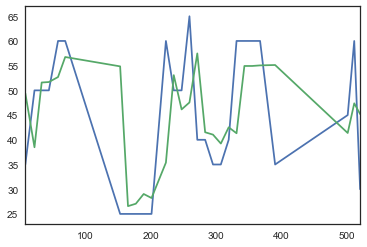

In [63]:
test_track.Wait.plot()
test_track.predictions.plot()

In [64]:
test_track[['previous_step1', 'previous_step2','Wait','predictions']]

,previous_step1,previous_step2,Wait,predictions
8,0,0,35,49.408448
22,35,0,50,38.484877
33,50,35,50,51.591427
44,50,50,50,51.686399
58,50,50,60,52.694543
69,60,50,60,56.750024
153,60,60,25,54.857486
165,25,60,25,26.572761
177,25,25,25,27.062967
189,25,25,25,29.033278


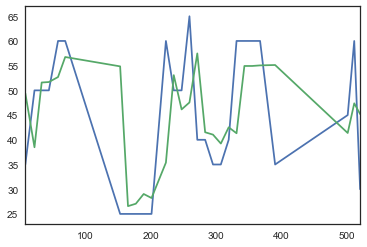

In [65]:
test_track.Wait.plot()
test_track.predictions.plot()

In [81]:
inspect(model)

NameError: name 'inspect' is not defined

In [82]:
model.__dict__

{'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
 'base_estimator_': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
 'bootstrap': True,
 'class_weight': None,
 'criterion': 'mse',
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'min_impurity_split',
  'random_state'),
 'estimators_': [DecisionTre

In [85]:
model.feature_importances_

array([1.07299713e-04, 3.52458666e-04, 6.77302963e-04, 1.14058549e-02,
       4.86298035e-04, 1.16188432e-03, 2.89215670e-03, 3.01644979e-03,
       3.26046247e-02, 5.04830090e-03, 3.83753031e-04, 1.56233120e-04,
       1.43977458e-03, 5.39229069e-04, 7.21993663e-03, 9.26487681e-04,
       3.30444008e-03, 3.72618330e-04, 8.65472569e-03, 1.31771284e-03,
       1.61263049e-01, 6.75570597e-03, 6.39818079e-04, 2.36995600e-04,
       6.79095399e-04, 1.41656388e-04, 3.55835350e-02, 1.62984959e-03,
       5.66808318e-03, 2.95532675e-01, 4.49990366e-03, 3.06490207e-04,
       1.08269514e-01, 1.06988011e-04, 5.38887714e-03, 3.16512654e-04,
       1.19737053e-03, 8.27547564e-03, 1.16685935e-03, 2.25472493e-04,
       3.65615843e-03, 3.83759217e-04, 9.54211483e-03, 5.17241779e-03,
       8.07495598e-04, 1.92547894e-03, 1.71675008e-01, 2.71989210e-04,
       1.82446025e-02, 2.09657066e-04, 6.81598488e-02])

AttributeError: 'RandomForestRegressor' object has no attribute 'classes_'